In [1]:
import argparse
import torch.multiprocessing as mp
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path
import logging

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
from vision_transformer import DINOHead
from utils import calculate_dataset_stats

from ISPY2MRI import ISPY2MRIDataSet, ISPY2MRIRandomPatchSSLDataset
from main_dino import *
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm

/home/t-9bchoy/.conda/envs/ssl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
dataset = ISPY2MRIRandomPatchSSLDataset("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transforms.ToTensor())
mean, std = calculate_dataset_stats(dataset)
transform = DataAugmentationDINO(
    (0.5, 1.0),
    (0.1, 0.5),
    8,
    mean,
    std,
    )
# TODO do not hardcode size
# tried 448, 512,
# dataset = IPSY2MRIRandomPatchSSLDataset("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transform, image_size=720)

# # sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
# data_loader = torch.utils.data.DataLoader(
#     dataset,
#     # sampler=sampler,
#     # batch_size=args.batch_size_per_gpu,
#     # num_workers=args.num_workers,
#     pin_memory=True,
#     drop_last=True,
# )


NameError: name 'ISPY2MRIRandomPatchSSLDataset' is not defined

In [6]:
dataset = ISPY2MRIDataSet("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transforms.ToTensor())
mean, std = calculate_dataset_stats(dataset)
# transform = DataAugmentationDINO(
#     (0.5, 1.0),
#     (0.1, 0.5),
#     8,
#     mean,
#     std,
#     )
# dataset = ISPY2MRIDataSet("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transform, image_size=720)


calculating dataset mean and standard deviation...


100%|██████████| 338/338 [00:00<00:00, 406.71it/s]


In [7]:
# TILES STATS
# mean = tensor(0.1046)
# std = tensor(0.0406)

# WHOLE IMG STATS
#  mean = tensor(0.0984)
# std = tensor(0.1406)
mean

tensor(0.0984)

In [8]:
std

tensor(0.1406)

In [20]:
num_examples=10
local_crops_number= 8

patch_lists = []
for i, entry in enumerate(dataset):
    patch_lists.append(entry)
    if i == num_examples:
        break

In [33]:
patch_lists[0][0][:2]

[tensor([[[-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          ...,
          [ 0.1650,  0.1093,  0.0256,  ..., -0.6994, -0.6994, -0.6994],
          [-0.0580, -0.0023,  0.0256,  ..., -0.6994, -0.6994, -0.6994],
          [-0.2253, -0.0580,  0.0535,  ..., -0.6994, -0.6994, -0.6994]]]),
 tensor([[[-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994],
          ...,
          [-0.6994, -0.6994, -0.6994,  ..., -0.6157, -0.6994, -0.6994],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6157],
          [-0.6994, -0.6994, -0.6994,  ..., -0.6994, -0.6994, -0.6994]]])]

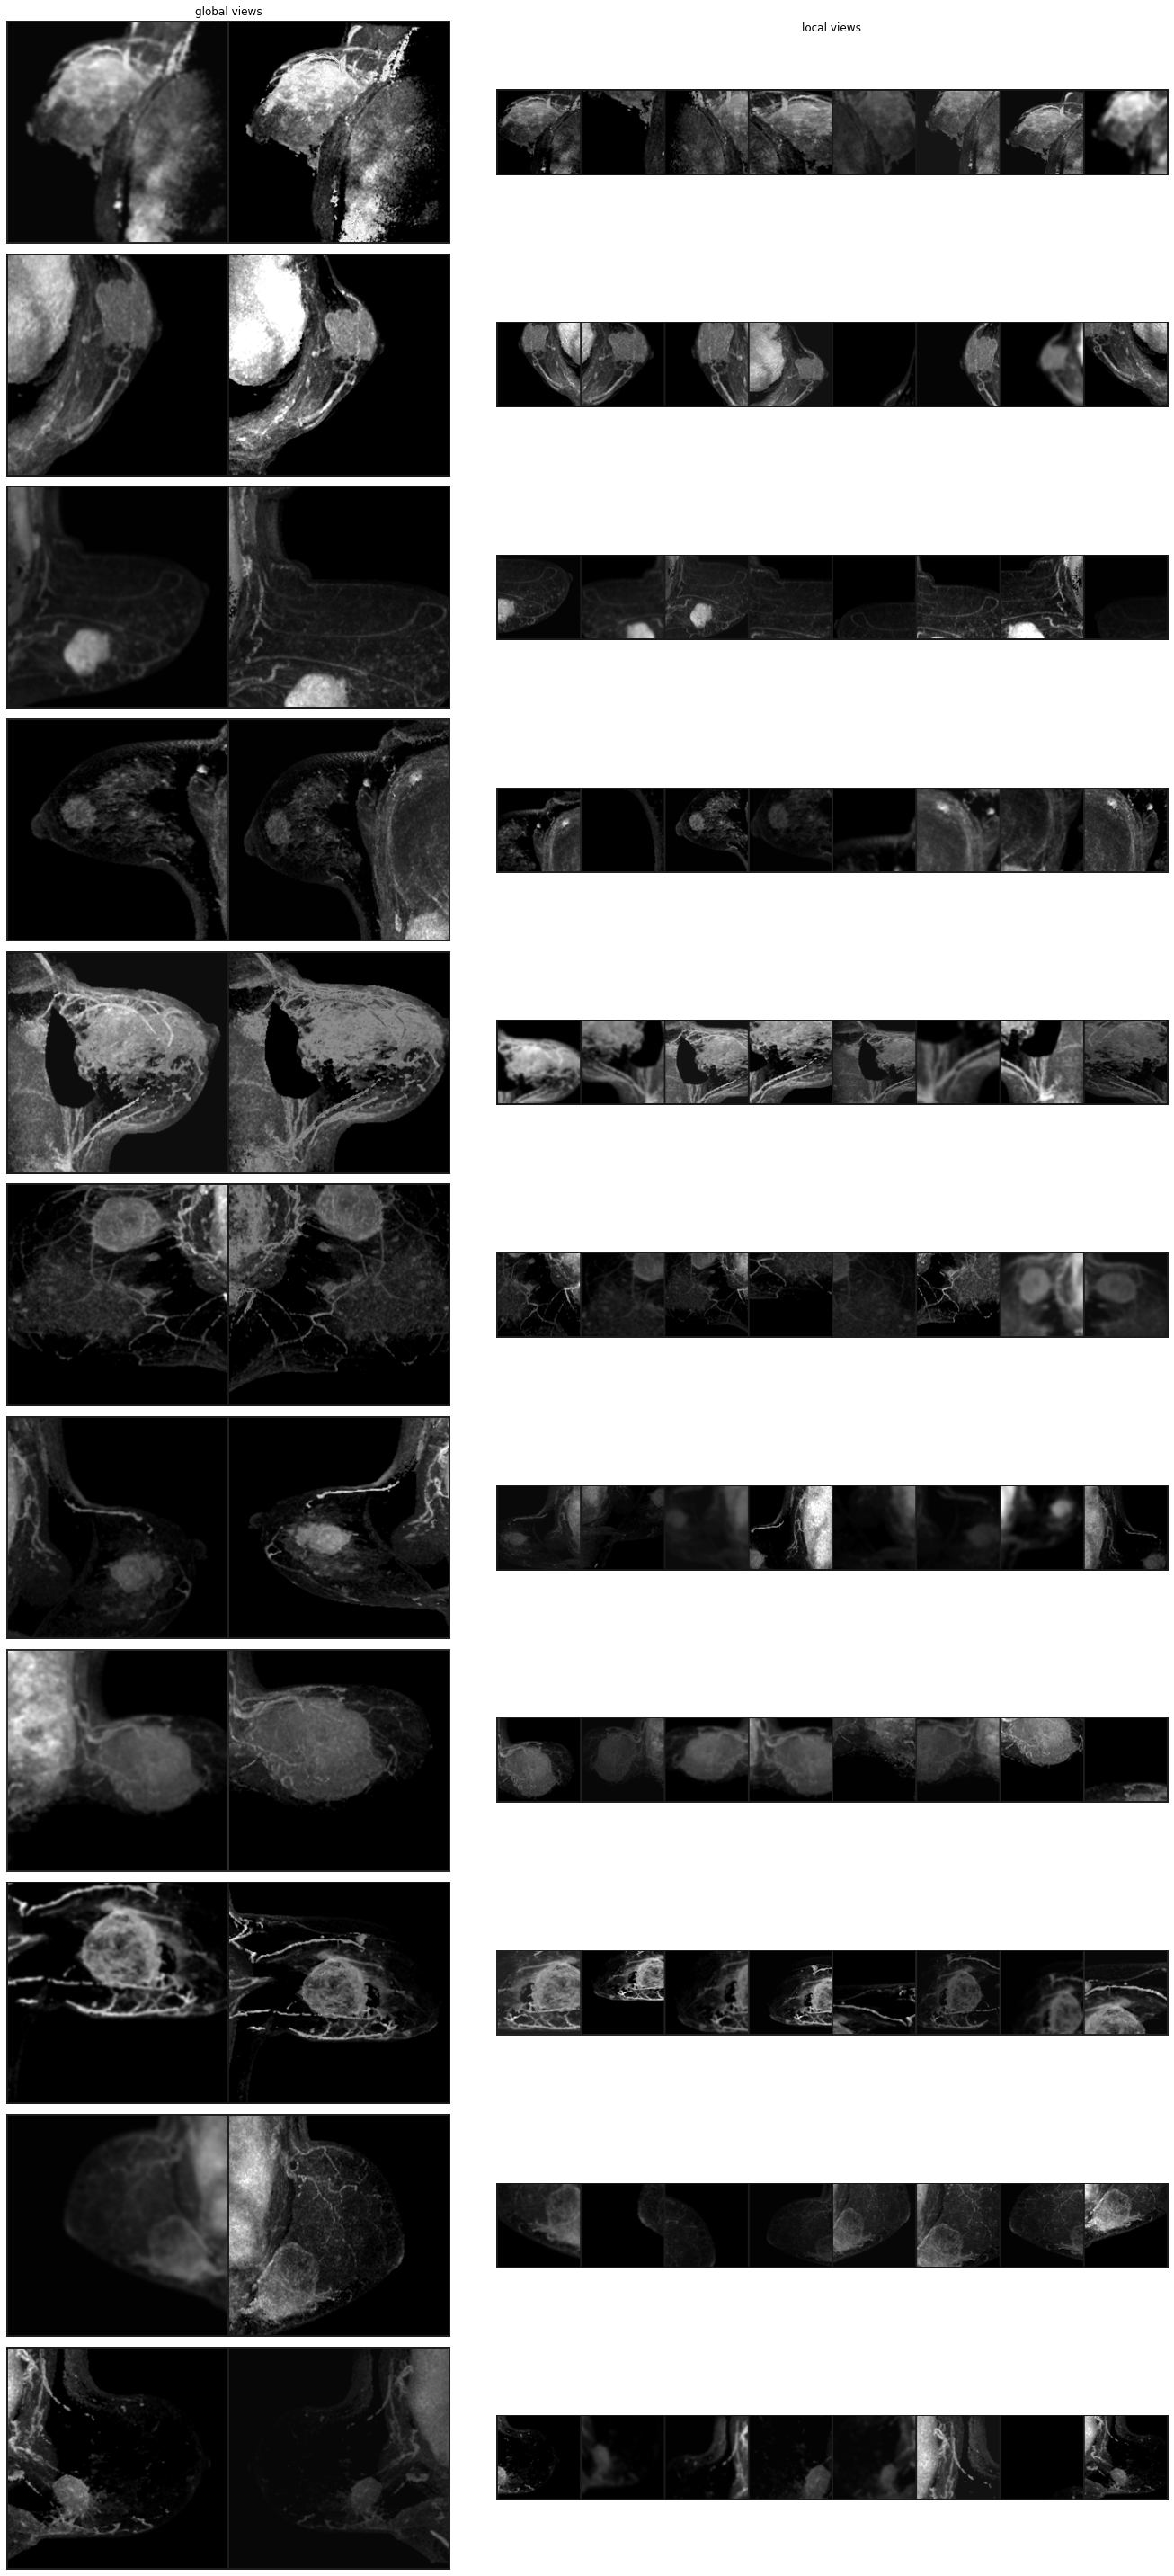

In [7]:
output_directory = "/home/t-9bchoy/dino/visualize_aug"
num_examples=10
local_crops_number= 8

patch_lists = []
for i, entry in enumerate(dataset):
    patch_lists.append(entry)
    if i == num_examples:
        break
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
}
plt.rcParams.update(rc)
f, axes = plt.subplots(11, 2, figsize=(20, 40))
axes[0][0].set_title("global views")
axes[0][1].set_title("local views", pad=65)     
for i, patches in enumerate(patch_lists):
    global_views = make_grid(patches[0][:2], nrow=2)[
        0,
        :,
    ]
    local_views = make_grid(patches[0][2:], nrow=local_crops_number)[
        0,
        :,
    ]
    axes[i][0].imshow(
        global_views,
        cmap="gray",
    )
    axes[i][1].imshow(
        local_views,
        cmap="gray",
    )
plt.tight_layout()
plt.savefig(os.path.join(output_directory, "augmentation_examples.png"))
plt.savefig(os.path.join(output_directory, "augmentation_examples.pdf"))

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(nrows=1,ncols=10,figsize=(40, 40))
fig.suptitle("transformed mips")
for it, (images, _) in enumerate(dataset):
    if it == 1:
        break
    for index, i in enumerate(images):
        axs[index].imshow(i.permute(1, 2, 0), cmap='gray'  )
plt.show()

dataset_notransformations = ISPY2MRIDataSet("ISPY2_VOLSER_uni_lateral_cropped_PE2", image_size=720)
fig, axs = plt.subplots(nrows=1,ncols=1)
fig.suptitle("original mip")
axs.imshow(dataset_notransformations[0][0], cmap='gray')
plt.show()

In [4]:
wid, hgt = dataset_notransformations[0][0].size
print("wid: " + str(wid))
print("hgt: " + str(hgt))

wid: 720
hgt: 720


In [9]:
dataset = ISPY2MRIRandomPatchSSLDataset("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transforms.ToTensor())

loader = DataLoader(
    dataset,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
means = []
stds = []
for i, j in enumerate(tqdm(loader)):
    j[0] = j[0] * 1.0  # pytorch will not compute mean/std of integers
    means.append(torch.mean(j[0]))
    stds.append(torch.std(j[0]))

mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

transform = DataAugmentationDINO(
    (0.5, 1.0),
    (0.1, 0.5),
    8,
    mean,
    std,
    )


100%|██████████| 86528/86528 [02:28<00:00, 581.94it/s]
/home/t-9bchoy/.conda/envs/ssl/lib/python3.8/site-packages/torchvision/transforms/transforms.py:890: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
mean = torch.tensor(0.1046)

In [4]:
std = torch.tensor(0.0406)

In [5]:
transform = DataAugmentationDINO(
    (0.5, 1.0),
    (0.1, 0.5),
    8,
    mean,
    std,
    )

/home/t-9bchoy/.conda/envs/ssl/lib/python3.8/site-packages/torchvision/transforms/transforms.py:890: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
dataset = ISPY2MRIRandomPatchSSLDataset("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transform, image_size=448)


In [7]:
num_examples=10
local_crops_number= 8

patch_lists = []
for i, entry in enumerate(dataset):
    patch_lists.append(entry)
    if i == num_examples:
        break

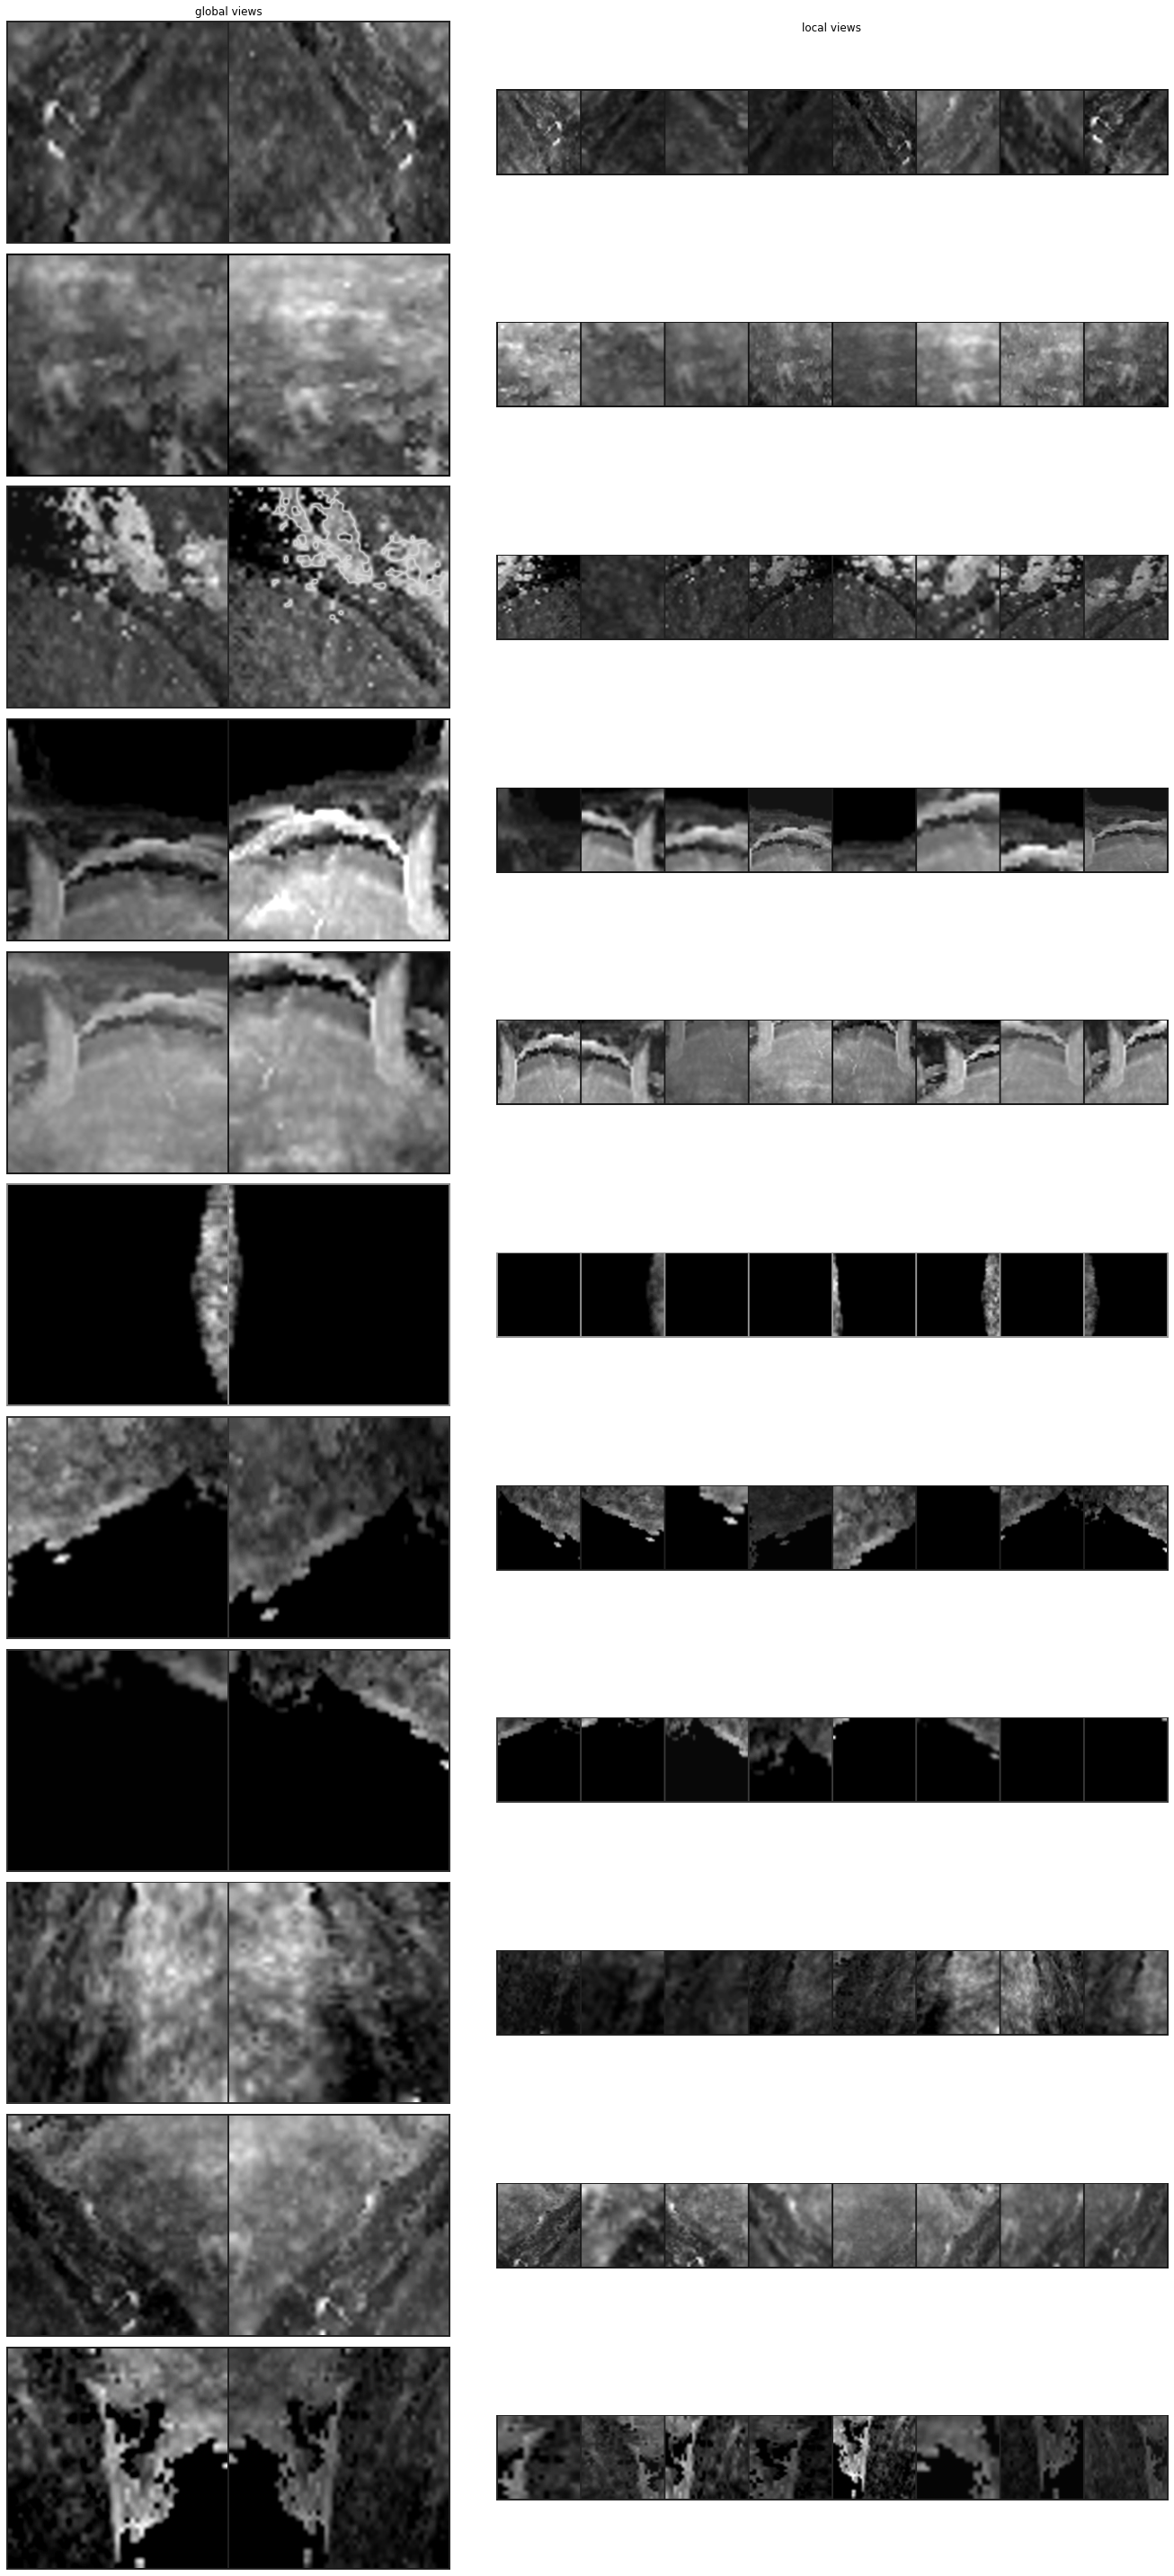

In [9]:
num_examples=10
local_crops_number= 8

patch_lists = []
for i, entry in enumerate(dataset):
    patch_lists.append(entry)
    if i == num_examples:
        break
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "axes.grid": False,
    "xtick.bottom": False,
    "xtick.labelbottom": False,
    "ytick.labelleft": False,
    "ytick.left": False,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
}
plt.rcParams.update(rc)
f, axes = plt.subplots(11, 2, figsize=(20, 40))
axes[0][0].set_title("global views")
axes[0][1].set_title("local views", pad=65)     
for i, patches in enumerate(patch_lists):
    global_views = make_grid(patches[0][:2], nrow=2)[
        0,
        :,
    ]
    local_views = make_grid(patches[0][2:], nrow=local_crops_number)[
        0,
        :,
    ]
    axes[i][0].imshow(
        global_views,
        cmap="gray",
    )
    axes[i][1].imshow(
        local_views,
        cmap="gray",
    )
plt.tight_layout()

In [12]:
mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

In [6]:
dataset = ISPY2MRIRandomPatchSSLDataset("ISPY2_VOLSER_uni_lateral_cropped_PE2", "training", transforms.ToTensor())
